In [281]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

<img src="images/tuile.jpg" alt='tuile' style='margin-left:0;' />


# Modèlisation de la température des tuiles d'un toit

Mon appartement est sous les toits. Je ressens donc l'effet direct du soleil sur la température chez moi. Je peux aussi facilement mesurer la température des tuiles avec un [thermomètre IR](https://www.google.fr/search?&q=IR+260-8S+thermometer+voltcraft), en passant le bras à travers le velux. J'ai donc voulu savoir s'il est possible de prédire correctement la température des tuiles à partir des données météo et de l'irradiation solaire. 


Le premier problème est d'obtenir les **données météo** heure par heure, ainsi que la valeur de l'**irradiation solaire**.  

La question suivante est de correctement décrire **les échanges thermiques** entre les tuiles et le reste de l'univers ... les tuiles sont chauffées par le soleil, et refroidit par l'air ambiant (convection) et l'échange de rayonnement avec le ciel (corps gris/noir). Aussi, de façon négligeable par la conduction à travers la structure du toit. 

<img src="images/sch_model02.jpg" width="380px" alt='schema mod02' />


Une fois l'ensemble des contributions chiffrées, on effectue la **résolution numérique** du système, ici assez simple. Et, enfin, on peut **valider le modèle** en comparant les résultats avec les mesures effectuées. 



In [282]:
coords_gps = (45.1973288, 5.7139923) # (latitude, longitude), degrée décimaux

# Période d'intérêt :
startday = pd.to_datetime('01/08/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday  = pd.to_datetime( 'now' ).tz_localize('Europe/Paris')

# Obtention des données météo

Le site web [DarkSky.net](https://darksky.net/dev/docs) fourni une API gratuite pour avoir les historiques de données météo à une certaine position GPS. Il existe aussi une libraire python [darkskylib](https://github.com/lukaskubis/darkskylib) simplifiant les échanges avec l'API.  

Par dessus, j'ai un module perso (`weatherfeed`) avec les fonctions de téléchargement jour par jour et de construction d'un [DataFrame pandas](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) unique.


In [283]:
import weatherfeed as wf

In [284]:
# téléchargement des données:
data = wf.buildmultidayDF(startday, lastday, coords_gps )

1, 2, 3, 4, 5, done


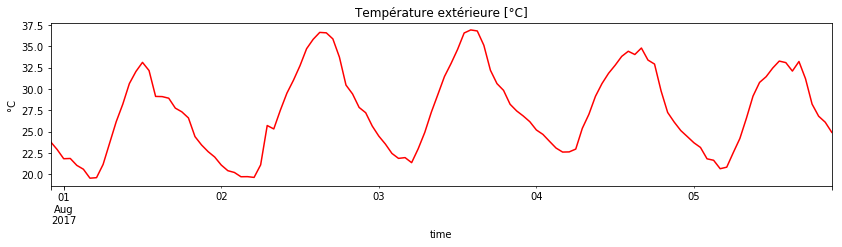

In [285]:
data['temperature'].plot(figsize=(14, 3), color='r' ); plt.ylabel('°C'); plt.title('Température extérieure [°C]');

Sont disponible aussi pleins d'autres mesures, et en particulier la _vitesse du vent_ et la _couverture nuageuse_.

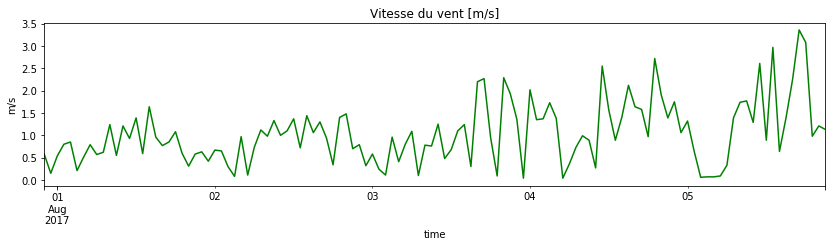

In [286]:
data['windSpeed'].plot(figsize=(14, 3), color='g' ); plt.ylabel('m/s'); plt.title('Vitesse du vent [m/s]');

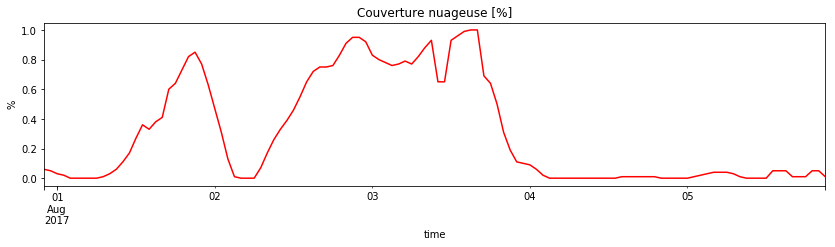

In [287]:
data['cloudCover'].plot(figsize=(14, 3), color='r' ); plt.ylabel('%'); plt.title('Couverture nuageuse [%]');

On aura besoin aussi du degrée d'humidité dans l'air:

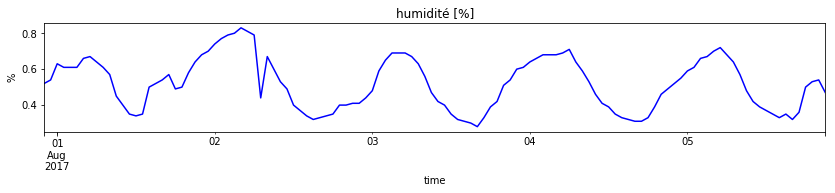

In [288]:
plt.figure()
data['humidity'].plot(figsize=(14, 2), color='b' ); plt.ylabel('%'); plt.title('humidité [%]');

Et il peut être intéressant aussi de voir l'effet de la pluie: 

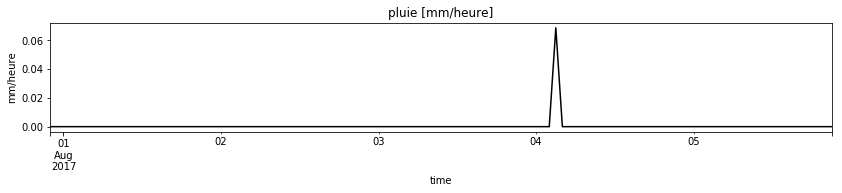

In [289]:
plt.figure()
data['precipIntensity'].plot(figsize=(14, 2), color='k' ); plt.ylabel('mm/heure'); plt.title('pluie [mm/heure]');

# Irradiation solaire

Le calcul de l'irradiation solaire est avant tout un problème géométrique avec l'angle de l'axe de rotation de la terre, la position de la terre sur son orbite et notre position sur le globe. Il existe une libraire python réalisant ce calcul: [pysolar.org](http://pysolar.org/). L'atténuation du flux solaire par l'épaisseur de la couche d'atmosphère traversée est aussi prise en compte. 

Un affinement possible du modèle prend en compte la hauteur de l'horizon. Ceci est surtout utile en région de montagne (horizon à ~ 15° le matin chez moi) ce qui recule l'heure du levée de soleil. Voir le notebook [ombres_montagnes](./ombres_montagnes.ipynb). 

De même, j'ai écris un module avec les quelques fonctions utiles me permettant d'obtenir un _Dataframe_ unique.


In [290]:
import sunradiation as sun

In [291]:
sundata = sun.buildmultidayDF( coords_gps, data.index  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


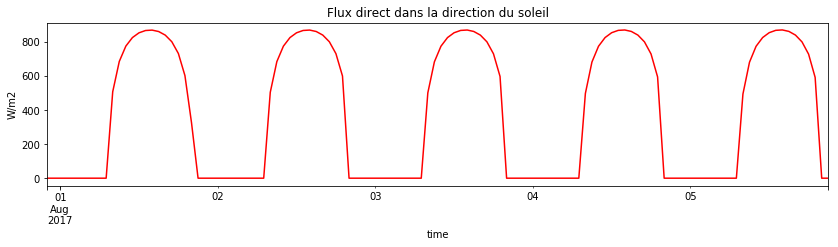

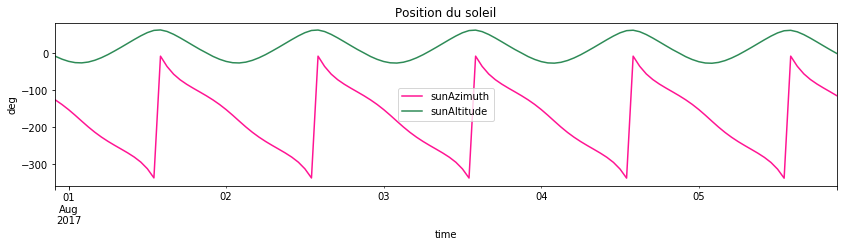

In [292]:
sundata['I0'].plot( figsize=(14, 3), style='r' );plt.ylabel('W/m2'); plt.title('Flux direct dans la direction du soleil');

plt.figure();
sundata['sunAzimuth'].plot( figsize=(14, 3), style='deeppink' );plt.ylabel('deg');
sundata['sunAltitude'].plot( figsize=(14, 3), style='seagreen' );
plt.title('Position du soleil'); plt.legend();


** Effet de la couverture nuageuse ? ** L'aspect difficile dans l'estimation de la radiation solaire arrivant au sol est de correctement prendre en compte l'effet des nuages, et de la radiation diffuse. Il ne semble pas avoir de modèle standard, mais différents modèles empiriques dépendant du type de nuages et du climat local...  

La formule la plus simple trouvée et qui me semble cohérente est :  $ \Phi =  I0 \, (1 - 0.75 \, C^{3.4}) $, $C$ étant la couverture nuageuse, entre 0 et 1. C'est à dire que même par un ciel entièrement nuageux il y a 25% du rayonement qui arrive au sol, et la relation est non linéaire pour les couvertures nuageuse intermédiaires.

    Solar and terrestrial radiation dependent on the amount and type of cloud. Kasten, F., & Czeplak, G. (1980). Solar energy, 24(2), 177-189.
    
L'effet et la prise en compte de la _radiation diffuse_ n'est pas encore claire pour moi, mais en comparant avec les valeurs de radiation données par Météoblue.com, j'obtiens les mêmes ordres de grandeurs.

In [293]:
cloud_attenuation = lambda c: 1 - 0.75* c**(3.4)

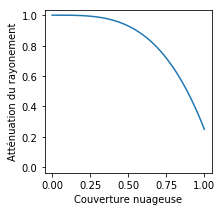

In [294]:
# graph
c = np.linspace(0, 1, 50); plt.figure(figsize=(3, 3));
plt.plot( c, cloud_attenuation(c)); plt.axis('equal'); plt.ylim([0, 1]); plt.xlabel('Couverture nuageuse');
plt.ylabel('Atténuation du rayonement');

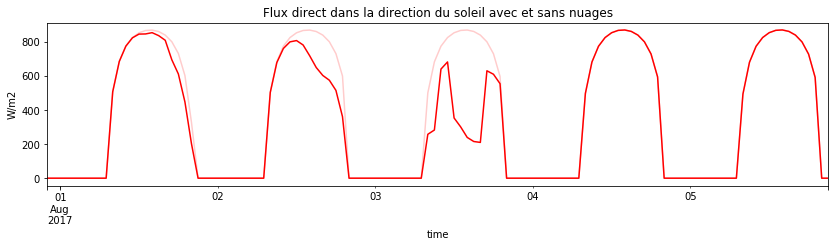

In [295]:
sundata['I_sol']  = sundata['I0']*cloud_attenuation( data['cloudCover']  )

# graph
sundata['I0'].plot( figsize=(14, 3), style='r', alpha=0.2 );plt.ylabel('W/m2'); 
sundata['I_sol'].plot( figsize=(14, 3), style='r' );plt.ylabel('W/m2');
plt.title('Flux direct dans la direction du soleil avec et sans nuages');

### Projection sur une surface inclinée
I0 est le flux dans la direction des rayons du soleil. Il faut donc projeter ce flux sur la surface receptrice qui est vue sous un certain angle, noté $\Gamma$ ici. Un peu de trigonométrie permet de calculer cet angle en fonction de l'orientation de la surface ($\theta$, $\varphi$) et de la position du soleil ($\theta_S$, $\varphi_S$) :

<img src="images/sch_angleprojection.jpg" width="400px" alt='schema mod02' />

Comme indiqué, on note $\Gamma$ l'angle entre le rayon du soleil $\vec r$ et la normal à la surface receptrice $\vec n$. Ces deux vecteurs sont unitaires. On obtient $cos\,\Gamma$ avec le produit scalaire de ces deux vecteurs :
$$
cos\,\Gamma = \vec r \bullet \vec n =
\begin{bmatrix} sin\, \varphi_S \,\, cos\, \theta_S  \\ cos\, \varphi_S \,\, cos\, \theta_S  \\ sin\, \theta_S \end{bmatrix} \bullet \begin{bmatrix} sin\, \varphi \,\, sin\, \theta  \\ cos\, \varphi \,\, sin\, \theta  \\ cos\, \theta \end{bmatrix} 
$$

qui se simplifie :
$$
cos\,\Gamma = cos( \varphi - \varphi_S )\, . \,sin\, \theta \,.\, cos \, \theta_S + cos\,\theta \,.\, sin \, \theta_S
$$


Une surface d'aire $A$ vue sous l'angle $\Gamma$ a une surface projetée $A . cos\, \Gamma$. Le flux reçu par la surface est donc $I. cos\, \Gamma$.

In [296]:
rad = lambda x: x*np.pi/180

def get_cosGamma(sundata_row, theta, phi):
    theta, phi = rad(theta), rad(phi)
    theta_S = rad( sundata_row['sunAltitude']  )
    phi_S = rad( sundata_row['sunAzimuth']  )
    
    cosGamma = np.cos( phi - phi_S )*np.sin( theta )*np.cos( theta_S ) \
            + np.cos( theta )*np.sin( theta_S )
    if  cosGamma<0 :  cosGamma = 0
    return cosGamma

L'angle du toit de mon appartement est d'environ 37° et l'orientation est de 50° par rapport au sud (50°+180° pour l'autre pan).

In [297]:
theta = 37   # deg
phi_bastille = 50  # deg
phi_vercors = 50+180  # deg

data['flux_bastille'] = sundata['I_sol'] * sundata.apply( get_cosGamma, axis=1, args=(theta, phi_bastille) )
data['flux_vercors'] =  sundata['I_sol'] * sundata.apply( get_cosGamma, axis=1, args=(theta, phi_vercors) )

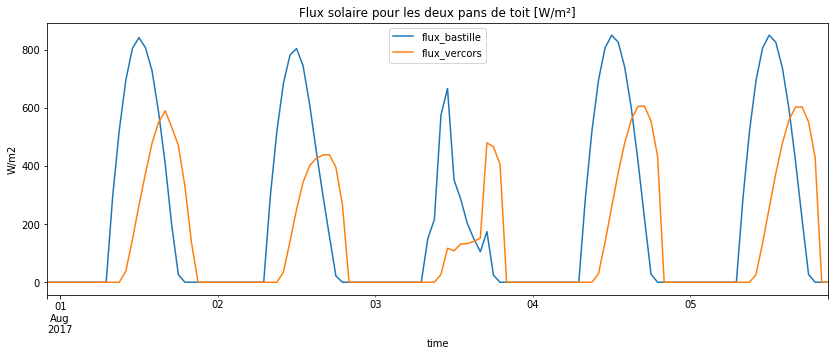

In [298]:
data[['flux_bastille', 'flux_vercors']].plot(figsize=(14, 5) )
plt.ylabel('W/m2');  plt.title('Flux solaire pour les deux pans de toit [W/m²]');

# Estimation des flux de chaleur sur les tuiles 

<img src="images/sch_model02.jpg" width="400px" alt='schema mod02' />

L'équilibre thermique des tuiles du toit est calculé en prennant en compte :
    - Le rayonnement solaire direct sur le toit (phi(t))
    - Le rayonnement propre des tuiles (corps noir)
    - Le rayonnement thermique du ciel (corps noir)
    - La convection avec l'air extérieur (forcée par le vent, ou bien naturelle)
    
En revanche, sont considérés comme négligeable : 
    - Le flux de chaleur à travers l'isolation du toit (~ 0.17 W/m2/K ).
    - L'inertie thermique des tuiles. 
    - La pluie, et l'humidité de l'air. 



## Refroidissement par convection avec l'air ambiant

La convection correspond aux échanges de chaleur avec l'air (un fluide) en mouvement. Ce mouvement peut être forcée par une source extérieure (ventilateur), ou dans notre cas le vent. Le mouvement de l'air peut aussi être induit par les variations de température suivant l'altitude, et donc de densité. L'air chaude monte parce que moins dense que l'air froid. On parle alors de convection naturelle. 

Le flux de chaleur par convection s'écrit sous la forme générale: $ h\, (T - T_{air}) $, où $h$ est le coefficient d'échange en W/m2/K. Sa valeur est habituellement entre 5 et 25 W/m2/K pour une surface en contact avec l'air ambiant. 

Une valeur plus précisse de ce coefficient peut être obtenue en considérant les propriétés de l'écoulement (laminaire vs turbulent, forcée vs naturelle, interne vs externe) et la vitesse du vent. On trouve, par exemple, dans ce [cours](http://www.legi.grenoble-inp.fr/people/Philippe.Marty/cours-convection-M2.pdf) un resumé des modèles physique permetttant d'estimer $h$ dans différentes situations. 

Á basse vitesse la convection naturelle prédomine, et $h$ est de l'ordre de 5 W/m2/K. Aux vitesses plus importantes, l'écoulement devient turbulent, et une loi en puissance donne une estimation de $h$ en fonction de la vitesse du vent.


Il semble que sur une structure réel les coefficients mesurées sont plus important. Voir par exemple : [A thermal model for photovoltaic panels under varying atmospheric conditions](http://www.nuigalway.ie/power_electronics/documents/applied_thermal_engineering_2010.pdf). Il existe plusieurs modèles empiriques. Celui de _Test et al._ semble ici donner de bon résultats. La convection naturelle n'est alors plus prise en compte (h(v=0)).

In [299]:
def coef_echange_old( vitesse_vent ):
    """ Fonction du coefficient d'échange pour la convection thermique
        vitesse_vent: m/s
        h : W/m2/K
    """
    
    k = 0.0262 # W/m/K, conductivité thermique
    nu = 1.57e-5 #  m2.s−1 , viscosité cinématique air
    Pr = 0.708 # Nombre de Prandl
    
    L = 4 # m, taille caractéristique, ( toit ou tuile ? )
    
    Reynolds = vitesse_vent*L/nu
    
    if Reynolds > 3e5:
        # convection forcée, turbulent, Pr < 50  (cf. page 15)
        h = k/L * 0.036 *  Reynolds**(4/5) * Pr**(1/3)
    else:
        # convection naturelle
        h = 5
        
def coef_echange( vitesse_vent ):
    """ Fonction du coefficient d'échange pour la convection thermique
        - empirique -
        vitesse_vent: m/s
        h : W/m2/K
    """
    
    # h = 5.7*vitesse_vent + 11.14 # Sturrock, Wind faced
    h = 2.56*vitesse_vent + 8.55 # Test et al. (outdoor)
    return h

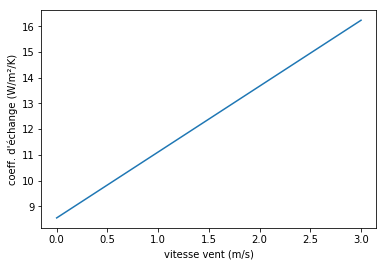

In [300]:
v_span = np.linspace( 0, 3, 100 )
h_span = [ coef_echange( v ) for v in v_span ]

plt.plot( v_span, h_span ); plt.xlabel('vitesse vent (m/s)');plt.ylabel("coeff. d'échange (W/m²/K)");

## Echange par radiation

En plus de la radiation direct du soleil, il faut prendre en compte les échanges thermiques par émission du corps noir, qui peuvent être important. Ces échanges ont lieu entre la surface des tuilles et l'atmosphère, qui émet lui aussi un rayonement électromagnétique du fait de sa température. On distingue les _short-wave radiation_, qui correspondent au rayonnement direct, et diffus, du soleil (UV, visible et proche infrarouge) des _long-wave radiation_ correspondant à l'émission du corps noir de l'atmosphère (T~10°C vs 6000°C du soleil).  

L'émission d'un corps à une température $T$ est donné par la loi de Stefan-Boltzmann :
$$
    P = \sigma \, \epsilon  \, \bar T ^4
$$

- $P$ est la puissance rayonnée dans le demi-espace, en W/m2
- $\sigma$ est la constante de Stefan-Boltzmann, W/m2/K4
- $\epsilon$ est l'émissivité de la surface
- $\bar T$ est la température de la surface, en Kelvin, c.a.d. $\bar T = T_{Celsius} + 273.15$


** Température du ciel : **  La température du ciel est généralement inférieure à la température ambiante, et elle dépend de la météo local, comme la couverture nuageuse et l'humidité. Un modèle simple permet de l'estimer. Voir cette [réponse](https://physics.stackexchange.com/questions/153839/) sur Stackexchange par exemple. 


**Facteur de forme :** Comme le toit est incliné, seul une portion du ciel est visible, ~ 75%. Ce facteur doit être pris en compte dans l'échange de chaleur par radiation (voir [view factor](https://en.wikipedia.org/wiki/View_factor)). 


In [301]:
""" Rayonement thermique du ciel
    ou autrement dit la température du ciel,
"""

def Goforth_skyrad( cloudCover, Tair_deg, RH ):
    """ Power radiated by the night sky
        see:  https://physics.stackexchange.com/q/153947
        https://physics.stackexchange.com/questions/153839/
        what-is-the-temperature-of-the-clear-night-sky-from-the-surface-of-earth
        "Cloud effects on thermal downwelling sky radiance," AeroSense 2002
    """
    K = 0.2   #  0.34 for very low clouds to 0.06 for very high clouds,
    T = Tair_deg + 273
    RH = RH*100

    Pthermal = ( 1 + K*cloudCover**2 ) * 8.78e-13 * T**5.852 * RH**0.07195
    
    return Pthermal

In [302]:
sigmaSB = 5.670373e-8 # Constante de Stefan-Boltzmann,   W.m-2.K-4

In [303]:
albedo_tuile = 0.36   # Coefficient de reflexion des tuiles
emissivite_tuile = 0.92

facteur_de_forme = 0.75  # portion du ciel visible par les tuiles (inclinaison du toit)

# Calcul de l'équilibre (statique)

L'effet de l'inertie themique des tuiles peut être à priori negligé. L'équation est alors un bilan statique des flux de chaleur :

$$
h(t)\,( T_{air}  - T  ) + (1-\alpha)\, \Phi(t) - \sigma_B \, \epsilon \, T^4 + P_{ciel}(t) = 0
$$

La resolution numérique est une recherche de zéro d'une fonction scalaire (de $T$). La méthode de Brent fonctionne très bien ([doc scipy](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.brentq.html)). Elle est une version améliorée de la méthode de dichotomie et permet donc de spécifier un intervalle de recherche, excluant d'emblée les valeurs non physique.

In [304]:
from scipy.optimize import brentq

In [305]:
def model02_apply( datarow, flux_name=None, disp=False  ):
      
    # Flux direct soleil :
    flux_soleil = datarow[ flux_name ]
    rayonement_soleil = (1 - albedo_tuile) * flux_soleil
    
    # Convection :
    T_air = datarow['temperature']
    h = coef_echange( datarow['windSpeed'] )   
    
    convection = lambda T:  h * ( T_air - T )
    
    # Rayonement 
    rayonement_toit = lambda T: sigmaSB * emissivite_tuile * ( T + 273 )**4
    
    rayonement_ciel = Goforth_skyrad( datarow['cloudCover'], T_air, datarow['humidity']  )
    
    # Bilan :
    somme_flux = lambda T: convection(T) + facteur_de_forme*( rayonement_ciel - rayonement_toit(T) ) \
                 + rayonement_soleil
        
    # Resolution numérique du zéro:
    Tmin, Tmax = -50, 200
    T_eq = brentq(somme_flux, Tmin, Tmax)
    
    # sauvegarde des valeurs
    results = {}
    results['T_eq'] = T_eq
    results['convection'] =  convection(T_eq)
    results['flux_soleil'] =  rayonement_soleil
    results['rayonement_ciel'] =  rayonement_ciel
    results['rayonement_toit'] =  rayonement_toit(T_eq)
    
    return pd.Series( results )

In [306]:
# Application du modèle aux données :
results_bastille = data.apply(model02_apply, axis=1, flux_name='flux_bastille')
#results_vercors = data.apply(model02_apply, axis=1, flux_name='flux_vercors')

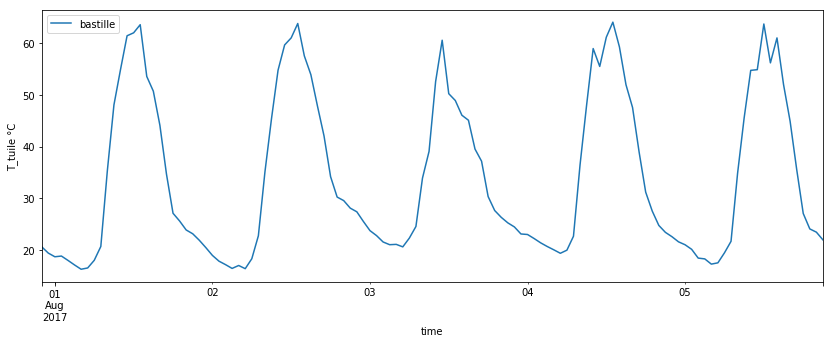

In [307]:
# graph

Ttuile =  pd.DataFrame({ 'bastille':results_bastille['T_eq'] } )# , 'vercors':results_vercors['T_eq'] })
Ttuile.plot(figsize=(14, 5) ); plt.ylabel('T_tuile °C');

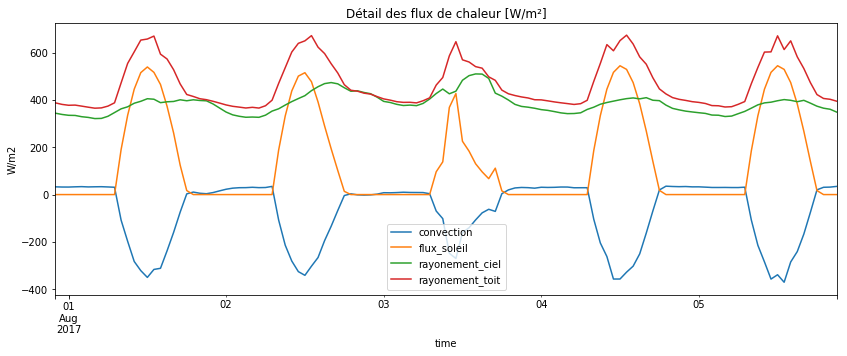

In [308]:
# graph - détail des flux
results_bastille.drop('T_eq', axis=1).plot( figsize=(14, 5) ) ;
plt.ylabel('W/m2');  plt.title('Détail des flux de chaleur [W/m²]');

# Validation du modèle

La mesure est effectuée avec un thermomètre ([DS18B20](https://www.google.fr/search?q=DS18B20)) placé entre un liteau et une tuile. J'ai pu le placer en pasant par un tube présent à travers l'isolation du toit. C'est-à-dire qu'il est relativement mal isolé de la température intérieure. 

In [309]:
import emoncmsfeed as getfeeds

In [310]:
dataframefreq = '20min'
feeds =  { 'T_tuile': 13 }

Tmesure = getfeeds.builddataframe( feeds, dataframefreq , startdate=startday )

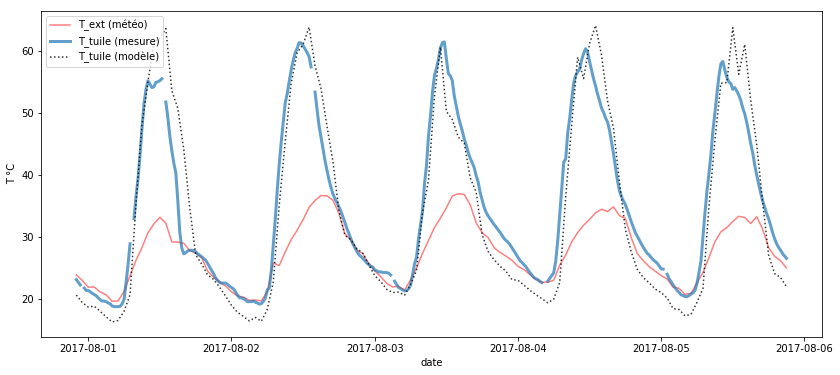

In [311]:
# graph
plt.figure( figsize=(14, 6) );  plt.ylabel('T °C'); plt.xlabel('date');
plt.plot( data['temperature'], '-r', alpha=0.5, label='T_ext (météo)' )
plt.plot( Tmesure, '-', alpha=0.7, label='T_tuile (mesure)', linewidth=3  )
plt.plot( Ttuile, 'k:', alpha=0.8, label='T_tuile (modèle)' );
plt.legend();

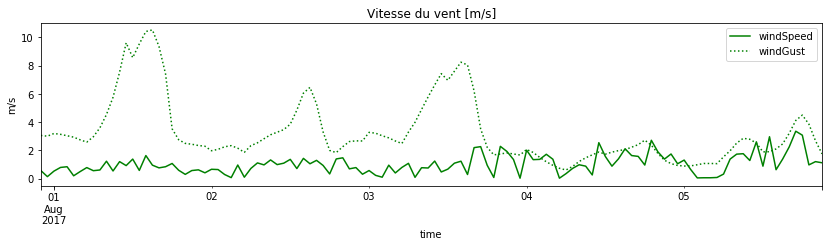

In [312]:
data['windSpeed'].plot(figsize=(14, 3), color='g' ); plt.ylabel('m/s'); plt.title('Vitesse du vent [m/s]');
data['windGust'].plot(figsize=(14, 3), color='g', linestyle=':'); plt.legend();

## Remarques 

Le modèle semble bien correspondre. 

Aussi, la température prédite la nuit est inférieure d'environ 4-5°C  par rapport à la température mesurée... Il peut avoir plusieurs raisons à cela : 
- Sous estimation du coefficent de convection... les tuiles serait alors en équilibre avec l'air ambiant ? mais la température maximale semble être quand même correctement prédite. 
- Sous estimation de la température du ciel nocturne ... ? ou sur estimation de l'émissivité des tuiles ?


# Todo
 * Améliorer l'isolation du capteur 
 * Comparer avec d'autres données météo (météoblue)
 * Effet des bourrasques de vent ? 
 * Effet de la pluie ? 
 * [ok] Faire plus de mesures 
 * [ok] Prendre en compte l'inertie dans l'épaisseur de la tuile... non utile